In [2]:
import scipy as sp
import scipy.io
import scipy.stats
import os
import numpy as np
import pandas as pd
import glob
import csv
from matplotlib import gridspec
import matplotlib.patches as patches

from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as mpl
from utils import plotting_utils as pu
from utils import utils
from utils import zscores
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

mpl.rc('font', **font)
%load_ext autoreload

In [3]:
log_df, unit_key_df = utils.load_data(os.getcwd())

In [4]:
bin_size = 0.025
window = [-1, 3]
edges = np.arange(window[0], window[1], bin_size)
unit_key_df = utils.calc_unit_stats(unit_key_df, log_df, bin_size)
log_df['spike_counts(stim_aligned)'] = log_df[
    'spike_times(stim_aligned)'].apply(lambda x: np.histogram(x,edges)[0]/bin_size)
unit_key_df = zscores.calc_z_scores(log_df, unit_key_df, bin_size, window)

C:\Users\efink\Documents\Github\Claustrum_analysis\utils\zscores.py:95: RuntimeWarning: Mean of empty slice
  act_resp_vis  = act_resp_vis.apply(lambda y: np.nanmean(y))


In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def multi_regress(uni_id, unit_key_df, y, factors,  formula, categorical = [], exclude_nl = False):
    
    unit_df = pd.DataFrame(unit_key_df[unit_key_df['uni_id'] == uni_id])
    unit_rows = log_df[log_df['uni_id'] == uni_id]

    all_variables = factors+y
    categoricals = np.array(factors)[categorical]
    
    if exclude_nl:
        unit_rows = unit_rows[unit_rows['response'] != 0]
    
    test_unit_factors = unit_rows.loc[:,all_variables]

    if 'trial_type' in test_unit_factors:
        test_unit_factors['trial_type'] = test_unit_factors['trial_type'].str.contains('Stim_Som')*1
        
    
    for cat in categoricals:
        test_unit_factors[cat] = pd.Categorical(test_unit_factors[cat])
#     from IPython.core.debugger import Tracer; Tracer()() 
   
    ### 100ms FR sliding bins######
    for t in range(0,155,1):
        test_unit_factors['FR_t'+str(t)] = test_unit_factors[y[0]].apply(lambda x: np.mean(x[t:t+5]))

    test_unit_factors = sm.add_constant(test_unit_factors)
#     from IPython.core.debugger import Tracer; Tracer()() 

    coef = pd.DataFrame()
    pVals = pd.DataFrame()
    tVals = pd.DataFrame()
    models = []
    for t in range(155):
        model = smf.ols(formula = 'FR_t'+str(t)+formula, data = test_unit_factors).fit()
        coef['t_'+str(t)] = model.params
        pVals['t_'+str(t)] = model.pvalues
        tVals['t_'+str(t)] = model.tvalues
#         from IPython.core.debugger import Tracer; Tracer()()

        models.append(model)
        
    return coef, pVals, tVals, models

C:\Users\efink\Anaconda3\envs\Claustrum_analysis\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
log_df['resp'] = (log_df['response'] != 0)*1
log_df['block'] = (log_df['block_type'] == 'Whisker')*1

## Full model including interaction terms

In [7]:
def regress_unit(uni_id, unit_key_df):
    form = '~ C(trial_type) + C(resp) + C(block) + C(trial_type):C(resp) + C(block):C(resp) + C(block):C(trial_type) + C(block):C(trial_type):C(resp)'
    coef, pVals, tvals, models = multi_regress(uni_id, unit_key_df, ['spike_counts(stim_aligned)'], 
                                               factors = ['trial_type', 'resp', 'block'],
                                               categorical = [0,1,2], formula = form)
    if uni_id in list(unit_key_df.loc[list(range(0, unit_key_df.shape[0], 50)), 'uni_id']):
        print(unit_key_df[unit_key_df['uni_id'] == uni_id].index)
    return coef, pVals

In [8]:
regress_results = [regress_unit(uni_id, unit_key_df) for uni_id in unit_key_df['uni_id']]

Int64Index([0], dtype='int64')
Int64Index([50], dtype='int64')


C:\Users\efink\Anaconda3\envs\Claustrum_analysis\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\efink\Anaconda3\envs\Claustrum_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\efink\Anaconda3\envs\Claustrum_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\efink\Anaconda3\envs\Claustrum_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Int64Index([100], dtype='int64')
Int64Index([150], dtype='int64')


KeyboardInterrupt: 

In [ ]:
all_trial_type_coef = pd.concat([regress_results[i][0].iloc[1,:] for i in range(len(regress_results))], axis = 1).T
all_resp_coef = pd.concat([regress_results[i][0].iloc[2,:] for i in range(len(regress_results))], axis = 1).T
all_block_coef = pd.concat([regress_results[i][0].iloc[3,:] for i in range(len(regress_results))], axis = 1).T
all_txResp_coef = pd.concat([regress_results[i][0].iloc[4,:] for i in range(len(regress_results))], axis = 1).T
all_bxResp_coef = pd.concat([regress_results[i][0].iloc[5,:] for i in range(len(regress_results))], axis = 1).T
all_txBlock_coef = pd.concat([regress_results[i][0].iloc[6,:] for i in range(len(regress_results))], axis = 1).T
all_txbxResp_coef = pd.concat([regress_results[i][0].iloc[7,:] for i in range(len(regress_results))], axis = 1).T

all_trial_type_pVals = pd.concat([regress_results[i][1].iloc[1,:] for i in range(len(regress_results))], axis = 1).T
all_resp_pVals = pd.concat([regress_results[i][1].iloc[2,:] for i in range(len(regress_results))], axis = 1).T
all_block_pVals = pd.concat([regress_results[i][1].iloc[3,:] for i in range(len(regress_results))], axis = 1).T
all_txResp_pVals = pd.concat([regress_results[i][1].iloc[4,:] for i in range(len(regress_results))], axis = 1).T
all_bxResp_pVals = pd.concat([regress_results[i][1].iloc[5,:] for i in range(len(regress_results))], axis = 1).T
all_txBlock_pVals = pd.concat([regress_results[i][1].iloc[6,:] for i in range(len(regress_results))], axis = 1).T
all_txbxResp_pVals = pd.concat([regress_results[i][1].iloc[7,:] for i in range(len(regress_results))], axis = 1).T

for df in [all_trial_type_coef, all_resp_coef, all_block_coef, all_txResp_coef, all_bxResp_coef, all_txBlock_coef,
          all_trial_type_pVals, all_resp_pVals, all_block_pVals, all_txResp_pVals, all_bxResp_pVals, all_txBlock_pVals]:
    df.index = unit_key_df['uni_id']
    
all_txResp_coef.head()

In [ ]:
import pickle

labels = ['trial_type', 'lick', 'block', 
         'txResp', 'bxResp', 'txBlock','txbxResp']
    
coefs = [all_trial_type_coef, all_resp_coef, all_block_coef, 
         all_txResp_coef, all_bxResp_coef, all_txBlock_coef,all_txbxResp_coef]
pVals = [all_trial_type_pVals, all_resp_pVals, all_block_pVals, all_txResp_pVals, 
                 all_bxResp_pVals, all_txBlock_pVals,all_txbxResp_pVals]

with open("coefs.txt", "wb") as fp:   #Pickling
    pickle.dump({labels[i]:coefs[i] for i in range(len(labels))}, fp)

with open("pVals.txt", "wb") as fp:   #Pickling
    pickle.dump({labels[i]:pVals[i] for i in range(len(labels))}, fp)


In [9]:
import pickle
with open("coefs.txt", "rb") as fp:   #Pickling
    coefs = pickle.load(fp)
with open("pVals.txt", "rb") as fp:   #Pickling
    pVals = pickle.load(fp)

In [10]:
def plot_regress(unit_num, unit_key_df, log_df, coefs, pVals, titles):
    size_mult = 0.5
    unit = unit_key_df.index[unit_num]
    unit_df = pd.DataFrame(unit_key_df.loc[unit]).T

    unit_rows = log_df.merge(unit_df, on=['mouse_name', 'date', 'cluster_name'], how = 'inner')

    t_NL = unit_rows.loc[unit_rows['trial_type'].str.contains('Som') & (unit_rows['response'] ==0),:]
    t_LR = unit_rows.loc[unit_rows['trial_type'].str.contains('Som') & (unit_rows['response'] ==1),:]
    t_LL = unit_rows.loc[unit_rows['trial_type'].str.contains('Som') & (unit_rows['response'] ==2),:]
    v_NL = unit_rows.loc[unit_rows['trial_type'].str.contains('Vis') & (unit_rows['response'] ==0),:]
    v_LR = unit_rows.loc[unit_rows['trial_type'].str.contains('Vis') & (unit_rows['response'] ==1),:]
    v_LL = unit_rows.loc[unit_rows['trial_type'].str.contains('Vis') & (unit_rows['response'] ==2),:]

    tt = [t_NL, t_LR, t_LL, v_NL, v_LR, v_LL]

    fig = mpl.figure(figsize = (16*size_mult,16*size_mult))

    gs1 = gridspec.GridSpec(1,1)
    gs2 = gridspec.GridSpec(1,1)
    gs3 = gridspec.GridSpec(7,1)

    gs1.update(bottom=0.5, top=0.95, left = 0.2, right = 0.86)
    gs2.update(bottom=0.5, top=0.95, left = 0.87, right = 0.9)
    gs3.update(bottom=0.15, top=0.47, left = 0.2, right = 0.86)


    ax = mpl.subplot(gs1[0, 0])
    patch_ax = mpl.subplot(gs2[0, 0], sharey = ax)

    colors = [ 'k','C0','#08306b', 'C7', '#cc4c02', 'C1',  ]

    trial_type = 0
    trial_total = 0
    hists = []
    for i in range(len(tt)):
        ras = tt[trial_type]
        spike_counts = []
        trial = 0
        for trial, spike in enumerate(ras['spike_times(stim_aligned)']):
            spike = spike[(spike>-1) & (spike<=3)]
            ax.vlines(spike, trial + trial_total + .5, trial + trial_total + 1.5)

            spike = spike[(spike>window[0]) & (spike<=window[1])]
            edges = np.arange(window[0], window[1]+bin_size*2, bin_size)
            count, _ = np.histogram(spike,edges)
            spike_counts.append(count)

        c1 = 0.5
        c2 = 0

        hists.append(np.array(spike_counts))
        patch_ax.add_patch(patches.Rectangle((0,trial_total+c1), 1,
                                       trial + c2, facecolor = colors[trial_type], alpha = 0.7))
        trial_total += trial
        trial_type += 1
    ax.plot([0, 0], [0, trial_total], 'r:')
    ax.plot([0.15, 0.15], [0, trial_total], 'r:')

    # ax.get_xaxis().set_visible(False)
    ax.set_xlim(-1,3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.set_ylabel('trial')
    ax.set_ylim([0, trial_total])


    patch_ax.set_xlim(0,1)
    patch_ax.axis('off')

    #######################################

    coef = pd.concat([coefs[i].iloc[unit, :] for i in range(len(coefs))], axis = 1).T
    pVals =  pd.concat([pVals[i].iloc[unit, :] for i in range(len(pVals))], axis = 1).T
    pos_sig_pVals = (pVals<0.05) & (coef>0)
    neg_sig_pVals = (pVals<0.05) & (coef<0)

    xvals = np.arange(0+.1,coef.shape[1]*0.025+.1, 0.025)-1

    for c in range(len(titles)):

        ax1 = mpl.subplot(gs3[c,0])
        ax1.plot(xvals, coef.iloc[c,:].as_matrix(), 'k')
        ax1.plot(xvals, [0] * len(xvals), 'C7--')
        ax1.plot(xvals[pos_sig_pVals.iloc[c,:].as_matrix()], [0]*sum(pos_sig_pVals.iloc[c,:].as_matrix()*1), 'sC2',markersize = 2, alpha = 0.5)
        ax1.plot(xvals[neg_sig_pVals.iloc[c,:].as_matrix()], [0]*sum(neg_sig_pVals.iloc[c,:].as_matrix()*1), 'sC3',markersize = 2, alpha = 0.5)

        ax1.text(.6, .65, titles[c] , transform=ax1.transAxes, color = 'k')

        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.set_xlabel('time from stim onset (s)')
        ax1.set_xlim(-1, 3)
        ax1.set_ylim(-20,50)


        if c != coef.shape[0]-1:
            ax1.spines['bottom'].set_visible(False)
            ax1.get_xaxis().set_visible(False)
    return fig

Cl405-19-171t1
Cl405-19-171t2


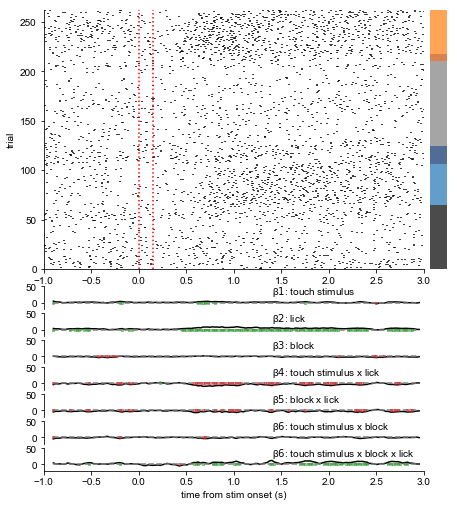

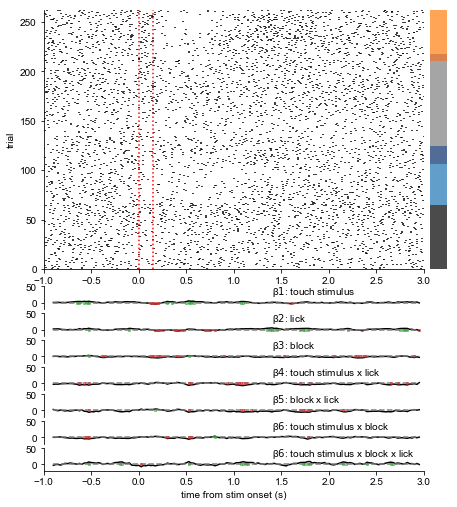

In [13]:
titles = ['β$1$: touch stimulus', 'β$2$: lick','β$3$: block',
              'β$4$: touch stimulus x lick','β$5$: block x lick', 'β$6$: touch stimulus x block',
             'β$6$: touch stimulus x block x lick']
for i in range(0,2):
    print(unit_key_df.loc[i, 'uni_id'])
    plot_regress(i, unit_key_df, log_df,list(coefs.values()),list(pVals.values()), titles)

### Will take three time points of interest:
*  pre-stimulus: -300-0 ms
*  stimulus: 0-150 ms
*  lick-period: 150-450 ms

In [53]:
b1_stim_period = coefs['trial_type'].iloc[:, 40:46].mean(axis = 1)
b2_lick_period = coefs['lick'].iloc[:, 46:58].mean(axis = 1)
b3_pre_stim_period = coefs['block'].iloc[:, 28:40].mean(axis = 1)

data = pd.concat((b1_stim_period,b2_lick_period,b3_pre_stim_period), axis = 1)
data.columns = ['-300-0ms', '0-150ms', '150-450ms']
data.head()

,-300-0ms,0-150ms,150-450ms
uni_id,,,
Cl405-19-171t1,0.501754,1.514286,-0.353234
Cl405-19-171t2,-3.354386,-2.026984,-0.133831
Cl405-19-171t3,-2.350877,-4.763492,-2.140299
Cl405-19-171t4,2.571930,-0.707937,0.985075
Cl405-19-171t5,-0.357895,1.257143,1.103980


In [54]:
data.index

Index(['Cl405-19-171t1', 'Cl405-19-171t2', 'Cl405-19-171t3', 'Cl405-19-171t4',
       'Cl405-19-171t5', 'Cl405-19-172t1', 'Cl405-19-172t2', 'Cl405-19-172t3',
       'Cl405-19-173t1', 'Cl405-19-173t2',
       ...
       'Cl611-07-173t1', 'Cl611-07-174t1', 'Cl611-07-176t1', 'Cl611-07-176t2',
       'Cl611-07-176t3', 'Cl611-07-176t4', 'Cl611-07-177t1', 'Cl611-07-177t2',
       'Cl611-07-177t3', 'Cl611-07-178t1'],
      dtype='object', name='uni_id', length=629)

In [55]:
id_units = pd.read_csv('identified_units.csv')
data['photo_id'] = 0
data.loc[data.index.isin(id_units['uni_id']), 'photo_id'] = 1

In [63]:
import altair as alt
grid_chart = alt.Chart(data).mark_point().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color = 'photo_id:N'
).properties(
    width = 250,
    height = 250,
).repeat(
    row=['-300-0ms', '0-150ms', '150-450ms'],
    column=['150-450ms', '0-150ms', '-300-0ms']).interactive(
)

grid_chart.savechart('gridchart.html')
grid_chart

<VegaLite 2 object>

In [62]:
chart = alt.Chart(data).mark_point().encode(
    x='0-150ms',
    y='150-450ms',
    color='photo_id:N',
).facet(column='photo_id:N').interactive()
chart.savechart('chart.html')
chart

<VegaLite 2 object>

## Restricted model

In [14]:
def regress_unit(uni_id, unit_key_df):
    form = '~ C(trial_type) + C(resp) + C(block)'
    coef, pVals, tvals, models = multi_regress(uni_id, unit_key_df, ['spike_counts(stim_aligned)'], 
                                               factors = ['trial_type', 'resp', 'block'],
                                               categorical = [0,1,2], formula = form)
    if uni_id in list(unit_key_df.loc[list(range(0, unit_key_df.shape[0], 50)), 'uni_id']):
        print(unit_key_df[unit_key_df['uni_id'] == uni_id].index)
    return coef, pVals

In [15]:
regress_results = [regress_unit(uni_id, unit_key_df) for uni_id in unit_key_df['uni_id']]

Int64Index([0], dtype='int64')
Int64Index([50], dtype='int64')


C:\Users\efink\Anaconda3\envs\Claustrum_analysis\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\efink\Anaconda3\envs\Claustrum_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\efink\Anaconda3\envs\Claustrum_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\efink\Anaconda3\envs\Claustrum_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Int64Index([100], dtype='int64')
Int64Index([150], dtype='int64')
Int64Index([200], dtype='int64')
Int64Index([250], dtype='int64')
Int64Index([300], dtype='int64')
Int64Index([350], dtype='int64')
Int64Index([400], dtype='int64')
Int64Index([450], dtype='int64')
Int64Index([500], dtype='int64')
Int64Index([550], dtype='int64')
Int64Index([600], dtype='int64')


In [17]:
all_trial_type_coef = pd.concat([regress_results[i][0].iloc[1,:] for i in range(len(regress_results))], axis = 1).T
all_resp_coef = pd.concat([regress_results[i][0].iloc[2,:] for i in range(len(regress_results))], axis = 1).T
all_block_coef = pd.concat([regress_results[i][0].iloc[3,:] for i in range(len(regress_results))], axis = 1).T

all_trial_type_pVals = pd.concat([regress_results[i][1].iloc[1,:] for i in range(len(regress_results))], axis = 1).T
all_resp_pVals = pd.concat([regress_results[i][1].iloc[2,:] for i in range(len(regress_results))], axis = 1).T
all_block_pVals = pd.concat([regress_results[i][1].iloc[3,:] for i in range(len(regress_results))], axis = 1).T

for df in [all_trial_type_coef, all_resp_coef, all_block_coef, 
          all_trial_type_pVals, all_resp_pVals, all_block_pVals]:
    df.index = unit_key_df['uni_id']
    

In [19]:
import pickle

labels = ['trial_type', 'lick', 'block']
    
coefs = [all_trial_type_coef, all_resp_coef, all_block_coef]
pVals = [all_trial_type_pVals, all_resp_pVals, all_block_pVals]

with open("coefs_restr.txt", "wb") as fp:   #Pickling
    pickle.dump({labels[i]:coefs[i] for i in range(len(labels))}, fp)

with open("pVals_restr.txt", "wb") as fp:   #Pickling
    pickle.dump({labels[i]:pVals[i] for i in range(len(labels))}, fp)


In [22]:
import pickle
with open("coefs_restr.txt", "rb") as fp:   #Pickling
    coefs = pickle.load(fp)
with open("pVals_restr.txt", "rb") as fp:   #Pickling
    pVals = pickle.load(fp)

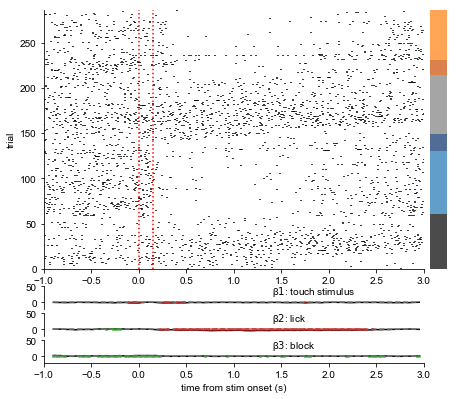

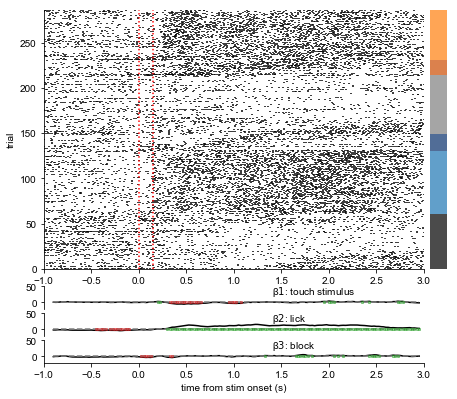

In [23]:
titles = ['β$1$: touch stimulus', 'β$2$: lick','β$3$: block']
for i in range(33,35):
    plot_regress(i, unit_key_df, log_df,list(coefs.values()),list(pVals.values()), titles)

### Will take three time points of interest:
*  pre-stimulus: -300-0 ms
*  stimulus: 0-150 ms
*  lick-period: 150-450 ms

In [24]:
b1_stim_period = coefs['trial_type'].iloc[:, 40:46].mean(axis = 1)
b2_lick_period = coefs['lick'].iloc[:, 46:58].mean(axis = 1)
b3_pre_stim_period = coefs['block'].iloc[:, 28:40].mean(axis = 1)

data = pd.concat((b1_stim_period,b2_lick_period,b3_pre_stim_period), axis = 1)
data.columns = ['-300-0ms', '0-150ms', '150-450ms']
data.head()

,-300-0ms,0-150ms,150-450ms
uni_id,,,
Cl405-19-171t1,0.010125,0.723415,-1.591277
Cl405-19-171t2,-1.921031,-1.727659,-1.122677
Cl405-19-171t3,1.008025,-3.118156,-1.303842
Cl405-19-171t4,1.917250,0.753489,0.837803
Cl405-19-171t5,-0.931558,-1.057635,0.244840


In [25]:
data.index

Index(['Cl405-19-171t1', 'Cl405-19-171t2', 'Cl405-19-171t3', 'Cl405-19-171t4',
       'Cl405-19-171t5', 'Cl405-19-172t1', 'Cl405-19-172t2', 'Cl405-19-172t3',
       'Cl405-19-173t1', 'Cl405-19-173t2',
       ...
       'Cl611-07-173t1', 'Cl611-07-174t1', 'Cl611-07-176t1', 'Cl611-07-176t2',
       'Cl611-07-176t3', 'Cl611-07-176t4', 'Cl611-07-177t1', 'Cl611-07-177t2',
       'Cl611-07-177t3', 'Cl611-07-178t1'],
      dtype='object', name='uni_id', length=629)

In [26]:
id_units = pd.read_csv('identified_units.csv')
data['photo_id'] = 0
data.loc[data.index.isin(id_units['uni_id']), 'photo_id'] = 1

In [43]:
import altair as alt
alt.Chart(data).mark_point().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color = 'photo_id:N'
).properties(
    width = 250,
    height = 250,
).repeat(
    row=['-300-0ms', '0-150ms', '150-450ms'],
    column=['150-450ms', '0-150ms', '-300-0ms']).interactive(
)


<VegaLite 2 object>

In [47]:
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['x'], empty='none')

chart = alt.Chart(data).mark_point().encode(
    x='0-150ms',
    y='150-450ms',
    color='photo_id:N',
)

# Firing rate analysis of three chosen epochs for opto-identified units



In [66]:
log_df.columns

Index(['mouse_name', 'date', 'block_type', 'trial_type', 'touch_stimulus',
       'vis_stimulus', 'response', 'trial_num', 'stim_onset', 'stim_offset',
       'licks_right', 'licks_left', 'spike_times', 'cluster_name',
       'spike_times(stim_aligned)', 'first_lick', 'last_lick',
       'spike_times(lick_aligned)', 'spike_times(last_lick_aligned)',
       'identified', 'correct', 'uni_id', 'spike_counts(stim_aligned)',
       'trial_label', 'resp', 'block'],
      dtype='object')